# Feature Engineering

# Por qué? Cuándo?

Los datos a veces pueden ser "tuneados" para **mejorar la capacidad de expresar el problema**, para **ayudar al modelo a aprender** más fácil.

Ej: en un problema de predecir tráfico en una calle por momento del día, en lugar de dar una columna de entrada con un datetime, dar 2 columnas con día de la semana y momento del día ya extraídos.

Se puede ver como parte de la fase de **limpieza y pre procesado**, aunque muchos lo piensan como algo diferente. También es borroso el límite con técnicas de selección de features (como las cosas que vimos en el análisis exploratorio).

En qué difieren? El preprocesado y limpieza más básico deja datos "listos". Feature engineering deja datos "más expresivos".

![](files/images/ml_process.svg)

# Cómo se hace?

- No es una ciencia exacta. 
- Depende mucho del **problema** y de nuestra habilidad para descubrir cómo **expresar mejor la información**.
- En algunos modelos y problemas **no** es necesario (ej: redes neuronales con imágenes).
- Es un proceso **iterativo**: idear features, probar modelos con las features, seleccionar, volver a empezar.

Hoy vamos a ver varios ejemplos comunes de creación de features. Pero no es una "lista completa de técnicas de feature engineering".

# Técnica 1: features no lineales para modelos lineales

a.k.a. Términos de interacción

**Para qué?** Para poder seguir usando un modelo simple lineal (Linear Regression, Logistic Regression), con datos que no son lineales.

Los modelos lineales solo pueden aprender **rectas**. 

Si mis datos no son una recta (regresión) o separables por una recta (clasificación), el modelo no sirve!

Pero si nuestros datos de entrada ya están elevados a algún exponente, ahora sí **una recta puede acomodarse a mis datos**.

In [1]:
%matplotlib inline
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import QuantileTransformer
font = {'size': 14}
plt.rc('font', **font)


In [2]:
def plot_linear_vs_quadratic():
    xl = np.linspace(-4, 7, 100)
    np.random.seed(42)
    x = np.random.uniform(-4, 7, size=20)
    y = (2 * x**2 + 3) + (np.random.rand(len(x)) - 0.5) * 15

    xt = x ** 2
    xlt = xl ** 2

    model_1 = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred_1 = model_1.predict(x.reshape(-1, 1))
    yl_pred_1 = model_1.predict(xl.reshape(-1, 1))
    em1 = metrics.mean_squared_error(y, y_pred_1, squared=False)

    model_2 = LinearRegression().fit(xt.reshape(-1, 1), y)
    y_pred_2 = model_2.predict(xt.reshape(-1, 1))
    yl_pred_2 = model_2.predict(xlt.reshape(-1, 1))
    em2 = metrics.mean_squared_error(y, y_pred_2, squared=False)

    fig, axis = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    ax = axis[0]
    ax.scatter(x, y)
    (p1,) = ax.plot(xl, yl_pred_1, c='r', label='Predicción sobre X')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Valor original y predicción. \n RMSE: {em1:.2f}')

    ax = axis[1]
    ax.scatter(xt, y)
    (p2,) = ax.plot(xlt, yl_pred_2, c='g', label='Predicción sobre X^2')
    ax.set_xlabel('x ^ 2')
    ax.set_title(f'Valor al cuadrado y predicción. \n RMSE: {em2:.2f}')

    ax = axis[2]
    ax.scatter(x, y)
    ax.plot(xl, yl_pred_2, c='g', label='Predicción sobre X^2')
    ax.set_xlabel('x')
    ax.set_title('Valor original y predicción \n obtenida con valor al cuadrado')

    plt.legend(handles=[p1, p2], title='Predicciones', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

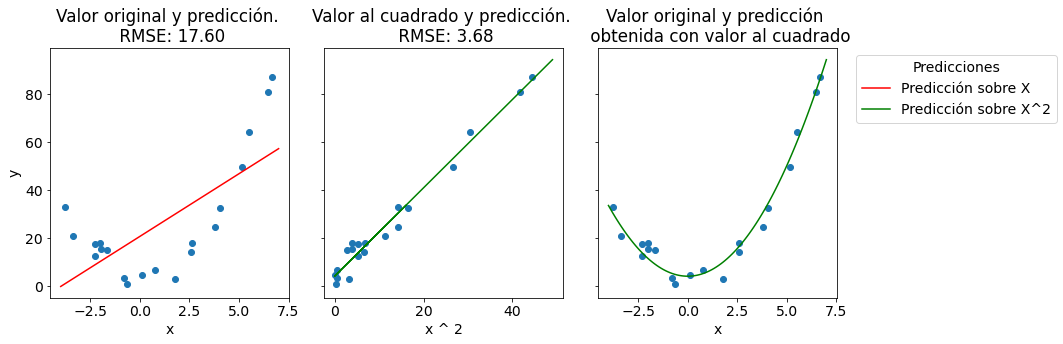

In [3]:
plot_linear_vs_quadratic()

- Se pueden incluso agregar features que operen entre variables! (ej: x1 * x2)
- **Super simple**.
- Me permite seguir usando modelos que son super rápidos y simples en casos que antes no podía.
- Hay que probar (qué features, a qué exponentes, etc).

![](files/images/non_linear_boundaries.png)

* Ver decision_boundaries_non_linear.ipynb

# Técnica 2: crear features extrayendo info de otras features

Básicamente, encontramos columnas que contienen **información "escondida"**, y separamos esa información en **nuevas columnas**.

![](files/images/titles_before.svg)

![](files/images/titles_after.svg)

Usos típicos:

- Momento del día.
- Solo fecha / solo hora.
- Medidas o coordenadas por separado (ej: latitud y longitud como valores separados).
- Región geográfica (extraer país, continente, zona, etc).
- Clase de producto / cliente / etc.

- Evita que el modelo tenga que aprender a extraer esa información. **Aprende más rápido**.
- Depende de nuestra viveza para descubrir nuevas features.

# Técnica 3: binning / redondeo de números

Muchas veces la info numérica puede tener demasiado detalle, **facilitando sobreentrenamiento** o **complicando encontrar límites** duros (ej: cambio de precio por kilo en envío).

Redondear o convertir a rangos fijos (binning) esos números puede ayudar mucho.

![](files/images/rounding_before.svg)

![](files/images/rounding_after.svg)

- Lo que estamos haciendo es **sacar ruido** y dejar información.
- **Puede evitar que el modelo se sobreentrene** en decimales/valores aleatorios que no definen al problema.
- Evita que el modelo tenga que aprender los rangos significativos por si solo. **Aprende más rápido**.
- Depende de nuestra habilidad para determinar el nivel de precisión significativo para cada feature.

# Técnica 4:  Quantile transformation

* Permite llevar los datos a una distribución uniforme o normal
* Es robusto a **outliers**

In [4]:
def plot_histogram_transformation():
    iris = datasets.load_iris()

    data = pd.DataFrame(iris.data, 
                        columns=[x[:-5].replace(' ', '_') for x in iris.feature_names])

    fig, axis = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    x = data.sepal_length
    x.hist(ax=axis[0], bins=20)
    axis[0].set_title('Distribución original')

    tr = QuantileTransformer(n_quantiles=50, output_distribution='uniform')
    tr.fit(x.to_frame())

    x2 = tr.transform(x.to_frame())
    pd.Series(x2.flatten()).hist(ax=axis[1], bins=20)
    axis[1].set_title('Distribución uniforme')

    tr = QuantileTransformer(n_quantiles=50, output_distribution='normal')
    tr.fit(x.to_frame())

    x2 = tr.transform(x.to_frame())
    pd.Series(x2.flatten()).hist(ax=axis[2], bins=20)
    axis[2].set_title('Distribución normal')

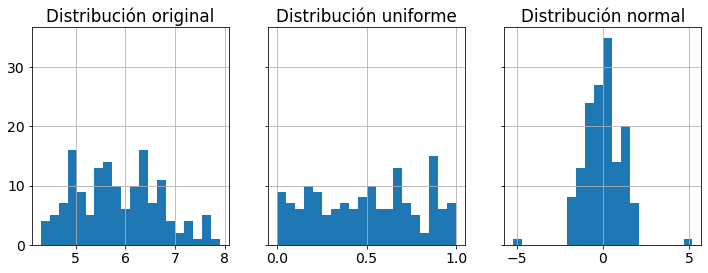

In [5]:
plot_histogram_transformation()

# Técnica 5: features a partir de datos pasados

Esto aplica cuando tenemos datos que se ubican en el **tiempo** (ej: ventas individuales con fechas).

Muchas veces podemos darle a cada sample un **"resumen" de datos pasados relacionados** a ese mismo sample.

![](files/images/time_grouping_before.svg)

![](files/images/time_grouping_after.svg)

- **CUIDADO!**: nunca incluir data futura!! (cuando tengamos que predecir demora de una venta, vamos a conocer solo el pasado, no tenemos bola de cristal)
- Puede aportar **mucha info nueva** al modelo, que de otra forma sería extremádamente difícil de aprender.
- Depende de nuestra habilidad para encontrar esa relaciones entre samples, no siempre es obvio.

# Y mucho más...

Como dijimos al inicio, depende mucho de nuestro **problema** y nuestra habilidad para **detectar información útil** en los datos.